In [ ]:
import pandas as pd
import numpy as np

from pathlib import Path
import os
from tqdm.notebook import tqdm

import torch
import torch.optim as optim
from torch.utils.data import Dataset
import torch.nn as nn
from torch.nn import functional

from dpipe.io import load_numpy

import warnings
warnings.filterwarnings("ignore")

import zipfile

from torchvision import transforms
import numpy as np
from skimage.transform import rotate

In [ ]:
pip install deep-pipe

     |████████████████████████████████| 71kB 5.9MB/s 
     |████████████████████████████████| 71kB 8.1MB/s 
  Created wheel for deep-pipe: filename=deep_pipe-0.0.10-cp37-none-any.whl size=95451 sha256=977782c6a0639c4d44af789ce28e23bdc325fe87c50fac58802cb09c9f2aba13
  Stored in directory: /root/.cache/pip/wheels/62/b9/87/9bf19b9fd140b8b34e1a7a847acafe5c45c98228f80e825513
  Created wheel for pdp: filename=pdp-0.3.0-cp37-none-any.whl size=6603 sha256=e5d43efcdc6e363ad2bcab8a07db8e6568605291dba17339f0a34cbe9f82ea33
  Stored in directory: /root/.cache/pip/wheels/84/fb/5e/afb783110614b3c1a4187e6f83e4f4ea0088fbdb82921013a2
  Created wheel for tensorboard-easy: filename=tensorboard_easy-0.2.3-cp37-none-any.whl size=16270 sha256=91d8035bd87ea0139a4f22601b6cb621ba31c8aa8ad861b38b249a6397e0a92a
  Stored in directory: /root/.cache/pip/wheels/b4/ed/f8/8d162ed84536607319e7180c751ccdd7f433078f8122fa0d93
  Created wheel for resource-manager: filename=resource_manager-0.11.4-cp37-none-any.whl size=1967

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
brats = zipfile.ZipFile('/content/gdrive/MyDrive/brats_slices_2.zip', 'r')
brats.extractall('/content')

In [ ]:
data_folder = Path('/content/brats_slices_2')
# df = []

# for path, _, files in tqdm(os.walk(data_folder)):
#     for file in files:
        
#         subject_id = path.split('/')[-1].split('_')[-1]
#         slice_id = file.split('.')[0].split('_')[0]
#         sample_id = f"{subject_id}_{slice_id}" # SubjectID_SliceIndex
#         is_mask = 'mask' in file
#         if is_mask:
#             mask = np.load(Path(path) / file, allow_pickle=True)
#             is_nonzero_mask =  np.any(mask)
#         else:
#             is_nonzero_mask = np.nan
        
#         df.append([Path(Path(path).stem) / file, sample_id, is_mask, subject_id, is_nonzero_mask])
        
# df = pd.DataFrame(df, columns = ['relative_path', 'sample_id', 'is_mask', 'subject_id', 'is_nonzero_mask'])
# print(df.is_nonzero_mask.value_counts())

# df.to_csv(data_folder / 'meta.csv')

In [ ]:
class BraTSDataset(Dataset):
    def __init__(self, meta: pd.DataFrame, source_folder: [str, Path], nonzero_mask=False, transform=None):
        if isinstance(source_folder, str):
            source_folder = Path(source_folder)
            
        if nonzero_mask:
            meta = meta[meta.sample_id.isin(meta.query('is_nonzero_mask == True').sample_id)]
            
        self.source_folder = source_folder
        self.meta_images = meta.query('is_mask == False').sort_values(by='sample_id').reset_index(drop=True)
        self.meta_masks = meta.query('is_mask == True').sort_values(by='sample_id').reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return self.meta_images.shape[0]

    def __getitem__(self, i):
        image = load_numpy(self.source_folder / self.meta_images.iloc[i]['relative_path'], allow_pickle=True)
        mask = load_numpy(self.source_folder / self.meta_masks.iloc[i]['relative_path'], allow_pickle=True)
        sample = image, mask
        
        if self.transform:
            image, mask = self.transform(sample)

        return torch.from_numpy(image).reshape(1, 240, 240), torch.from_numpy(mask).reshape(1, 240, 240).double()

In [ ]:
def train_step(images, labels, architecture, criterion, optimizer):
    device = ("cuda" if torch.cuda.is_available() else 'cpu')
    images, labels = images.to(device), labels.to(device)
    architecture.train() # enforce training regime

    pred_logits = architecture(images)
    loss = criterion(pred_logits, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.data.cpu().numpy()

In [ ]:
def conv_3x3(in_c, out_c):
    return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
    )

def conv(in_c, out_c):
    return nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)

class Unet(nn.Module):
    """
   16       (+)       16->8->1
    32      (+)      32
      64    (+)    64
       128  (+)  128
        256 (+) 256
          256->256
    """
    
    def __init__(self, ):
        super().__init__()
        
        self.max_pool2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.down_conv_1 = conv_3x3(1, 16)
        self.down_conv_2 = conv_3x3(16, 32)
        self.down_conv_3 = conv_3x3(32, 64)
        self.down_conv_4 = conv_3x3(64, 128)
        self.down_conv_5 = conv_3x3(128, 256)
        self.bottleneck_conv = conv_3x3(256, 256)
        
        self.upsample_1 = conv(256, 256)
        self.up_conv_1 = conv_3x3(256, 128)
        self.upsample_2 = conv(128, 128)
        self.up_conv_2 = conv_3x3(128, 64)
        self.upsample_3 = conv(64, 64)
        self.up_conv_3 = conv_3x3(64, 32)
        self.upsample_4 = conv(32, 32)
        self.up_conv_4 = conv_3x3(32, 16)
        self.upsample_5 = conv(16, 16)
        self.up_conv_5 = conv_3x3(16, 8)
        
        self.segm = nn.Sequential(
            nn.Conv2d(8, 8, kernel_size=3, padding=1),
            nn.Conv2d(8, 1, kernel_size=1)
        )
        
        
    def forward(self, x):
        
        # down/contracting
        x1 = self.down_conv_1(x)
        x2 = self.max_pool2x2(x1)
        
        x3 = self.down_conv_2(x2)
        x4 = self.max_pool2x2(x3)
        
        x5 = self.down_conv_3(x4)
        x6 = self.max_pool2x2(x5)
        
        x7 = self.down_conv_4(x6)
        x8 = self.max_pool2x2(x7)
        
        x9 = self.down_conv_5(x8)
        x10 = self.max_pool2x2(x9)
        
        x = self.bottleneck_conv(x10)
        
        # up/expansive
        x = self.upsample_1(functional.interpolate(x, x9.shape[2:], mode='bilinear', align_corners=False))
        x = self.up_conv_1(x+x9)
        
        x = self.upsample_2(functional.interpolate(x, x7.shape[2:], mode='bilinear', align_corners=False))
        x = self.up_conv_2(x+x7)
        
        x = self.upsample_3(functional.interpolate(x, x5.shape[2:], mode='bilinear', align_corners=False))
        x = self.up_conv_3(x+x5)
        
        x = self.upsample_4(functional.interpolate(x, x3.shape[2:], mode='bilinear', align_corners=False))
        x = self.up_conv_4(x+x3)
        
        x = self.upsample_5(functional.interpolate(x, x1.shape[2:], mode='bilinear', align_corners=False))
        x = self.up_conv_5(x+x1)

        # segm
        x = self.segm(x)
        
        return x

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/meta.csv', index_col=0)

df = df.sort_values(by=['subject_id'], ignore_index=True)

train_size = int(0.8 * df.shape[0])
val_size = df.shape[0] - train_size

border_id = df['subject_id'][train_size]

train_df = df[df['subject_id'] < border_id]
val_df = df[df['subject_id'] >= border_id]

In [ ]:
def random_crop(sample):
    
    image, mask = sample
    delta_h, delta_w = 20, 20
    h, w = image.shape
    new_h, new_w = 120, 120
    top = np.random.randint(0, h - delta_h - new_h)
    left = np.random.randint(0, w - delta_w - new_w)

    image = image[top: top + new_h,
                  left: left + new_w]
    
    mask = mask[top: top + new_h,
                  left: left + new_w]
    
    return image, mask

def random_rotate(sample):
    
    image, mask = sample
    angles = [0, 90, 180, 270]
    np.random.shuffle(angles)
    angle = angles[0]    
    return rotate(image, angle), rotate(mask, angle)
    
def to_tensor(sample):
    image, mask = sample
    image = image.reshape(1, image.shape[0], image.shape[1])
    return torch.from_numpy(image), np.sum(mask, axis=(0,1)).astype(bool)

In [ ]:
train_transform = transforms.Compose([
                    random_crop,
                    random_rotate,
                    to_tensor
            ])
val_transform = to_tensor

train_dataset = BraTSDataset(train_df, data_folder, nonzero_mask=True)
val_dataset = BraTSDataset(val_df, data_folder, nonzero_mask=True)


# train_dataset = BraTSDataset(train_df, data_folder, nonzero_mask=True, transform=train_transform)
# val_dataset = BraTSDataset(val_df, data_folder, nonzero_mask=True, transform=val_transform)

train_loader = torch.utils.data.DataLoader(train_dataset,
                                             batch_size=128, shuffle=True,
                                             num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset,
                                             batch_size=128, shuffle=False,
                                             num_workers=2)

In [ ]:
device = ("cuda" if torch.cuda.is_available() else 'cpu')
model = Unet().to(device)

criterion = nn.BCEWithLogitsLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(5):
    epoch_loss = 0
    for X_batch, y_batch in tqdm(train_loader):

        loss = train_step(X_batch, y_batch, model, criterion, optimizer)
        
        epoch_loss += loss     

    print(f'Epoch {epoch+0:03}: | Loss: {epoch_loss/len(train_loader):.5f}')


Epoch 000: | Loss: 0.26511



Epoch 001: | Loss: 0.05085



Epoch 002: | Loss: 0.03958



Epoch 003: | Loss: 0.03532



Epoch 004: | Loss: 0.02683


In [ ]:
torch.save(model.state_dict(), '/content/unet.pth')

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

4973


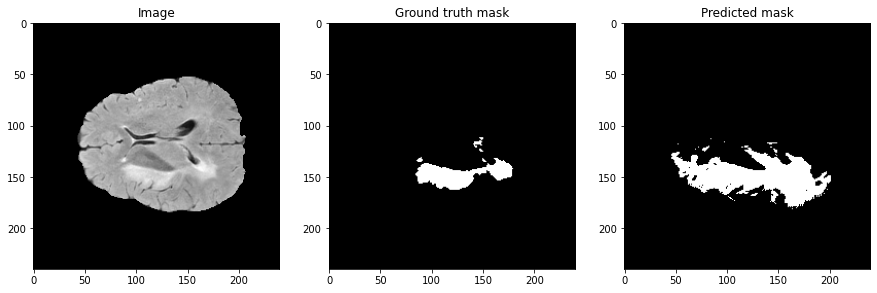

In [ ]:
_ = model.load_state_dict(torch.load('/content/unet.pth'))
_ = model.eval()

x, y = val_dataset[1000]
y_pred = np.exp(model(x.reshape(1,1,240,240).to('cuda'))[0].to('cpu').detach().numpy()) > 0.5

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(x[0, ...], cmap='gray')
ax[0].set_title('Image')
ax[1].imshow(y[0, ...], cmap='gray')
ax[1].set_title('Ground truth mask')
ax[2].imshow(y_pred[0, ...], cmap='gray')
ax[2].set_title('Predicted mask');

In [ ]:
from dpipe.im.metrics import dice_score

dice = []
for i in tqdm(range(len(val_dataset))):
    x, y = val_dataset[i]
    y = y.detach().numpy().astype(bool)
    y_pred = np.exp(model(x.reshape(1,1,240,240).to('cuda'))[0].to('cpu').detach().numpy()) > 0.1
    dice.append(dice_score(y, y_pred))

np.mean(dice), np.std(dice)

(0.5340182212711252, 0.26906466389666245)